## Intro to pymc- pymc3

- How to be a Bayesian in Python: https://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/
- https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-041-probabilistic-systems-analysis-and-applied-probability-fall-2010/video-lectures/lecture-21-bayesian-statistical-inference-i/
- MCMC for dummies; https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.v3.ipynb
- bayesian neuralnets: http://twiecki.github.io/blog/2016/06/01/bayesian-deep-learning/
- Bayesian Machine learning: http://fastml.com/bayesian-machine-learning/
- Bayesian Linear Regression Models with PyMC3: https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3
- MCMC for bayesian inference: https://www.quantstart.com/articles/Markov-Chain-Monte-Carlo-for-Bayesian-Inference-The-Metropolis-Algorithm
- Bayesian regression http://www.databozo.com/2014/01/17/Exploring_PyMC3.html

Probabilistic programming (PP) allows flexible specification of Bayesian statistical models in code. PyMC3 is a new, open-source PP framework with an intuitive and readable, yet powerful, syntax that is close to the natural syntax statisticians use to describe models. 

PyMC3 features next-generation Markov chain Monte Carlo (MCMC) sampling algorithms such as the No-U-Turn Sampler (NUTS; Hoffman, 2014), a self-tuning variant of Hamiltonian Monte Carlo (HMC; Duane, 1987). This class of samplers works well on high dimensional and complex posterior distributions and allows many complex models to be fit without specialized knowledge about fitting algorithms. HMC and NUTS take advantage of gradient information from the likelihood to achieve much faster convergence than traditional sampling methods, especially for larger models. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo, which means you usually don’t need to have specialized knowledge about how the algorithms work. PyMC3, Stan (Stan Development Team, 2014), and the LaplacesDemon package for R are currently the only PP packages to offer HMC.

Probabilistic programming in Python confers a number of advantages including multi-platform compatibility, an expressive yet clean and readable syntax, easy integration with other scientific libraries, and extensibility via C, C++, Fortran or Cython. These features make it relatively straightforward to write and use custom statistical distributions, samplers and transformation functions, as required by Bayesian analysis.

While most of PyMC3’s user-facing features are written in pure Python, it leverages Theano (Bergstra et al., 2010) to transparently transcode models to C and compile them to machine code, thereby boosting performance. Theano is a library that allows expressions to be defined using generalized vector data structures called tensors, which are tightly integrated with the popular NumPy ndarray data structure, and similarly allow for broadcasting and advanced indexing, just as NumPy arrays do. Theano also automatically optimizes the likelihood’s computational graph for speed and provides simple GPU integration.

Here, we present a primer on the use of PyMC3 for solving general Bayesian statistical inference and prediction problems. We will first see the basics of how to use PyMC3, motivated by a simple example: installation, data creation, model definition, model fitting and posterior analysis. Then we will cover two case studies and use them to show how to define and fit more sophisticated models. Finally we will show how to extend PyMC3 and discuss other useful features: the Generalized Linear Models subpackage, custom distributions, custom transformations and alternative storage backends.

# Linear regression pymc3

- Tutorial from: http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/


This tutorial focuses in 
- How the Bayesian Revolution in many scientific disciplines is hindered by poor usability of current Probabilistic Programming languages.
- A gentle introduction to Bayesian linear regression and how it differs from the frequentist approach.
- A preview of PyMC3 (currently in alpha) and its new GLM submodule I wrote to allow creation and estimation of Bayesian GLMs as easy as frequentist GLMs in R.

While the theoretical benefits of Bayesian over Frequentist stats have been discussed at length elsewhere (see Further Reading below), there is a major obstacle that hinders wider adoption -- usability.

This is mildly ironic because the beauty of Bayesian statistics is their generality. Frequentist stats have a bazillion different tests for every different scenario. In Bayesian land you define your model exactly as you think is appropriate and hit the Inference Button(TM) (i.e. running the magical MCMC sampling algorithm).

Yet when I ask my colleagues why they use frequentist stats (even though they would like to use Bayesian stats) the answer is that software packages like SPSS or R make it very easy to run all those individuals tests with a single command (and more often then not, they don't know the exact model and inference method being used).

While there are great Bayesian software packages like JAGS, BUGS, Stan and PyMC, they are written for Bayesians statisticians who know very well what model they want to build.

Unfortunately, "the vast majority of statistical analysis is not performed by statisticians" -- so what we really need are tools for scientists and not for statisticians.

In the interest of putting my code where my mouth is I wrote a submodule for the upcoming PyMC3 that makes construction of Bayesian Generalized Linear Models (GLMs) as easy as Frequentist ones in R.

# Bayesian  Linear regression: 2D

I will start here with the simplest GLM -- linear regression. In general, frequentists think about Linear Regression as follows:

\begin{equation}
Y = \beta X + \epsilon 
\end{equation}

in this equation:
- $Y$ is the output we want to predict (or dependent variable)
- $X$ is our predictor (or independent variable)
- $\beta$ are the coefficients (or parameters) of the model we want to estimate.
- $\epsilon$ is an error term which is assumed to be normally distributed.

We can then use ordinary least squares or maximum likelihood to find the best fitting $\beta$.




### Probabilistic reformulation

Bayesians take a probabilistic view of the world and express this model in terms of probability distributions. Our above linear regression can be rewritten to yield:

\begin{equation}
Y \sim \mathcal{N} ( \beta X, \sigma^2)
\end{equation}

In words, we view $Y$ as a random variable (or random vector) of which each element (datapoint) is distributed according to a Normal distribution. The mean of this normal distribution is provided by our linear predictor with variance $\sigma^2$.

While this is essentially the same model there are two critivcal advantages of Bayesian estimation:

- **Priors**: We can quanntify any prior knowledge we might have by placing priors on the parameters. For example, if we think that $\sigma$ is likely to be small we would choose a prior with more probability mass on low values.

- **Quantifying uncertainty**: We do not get a single estimate of $\beta$ as above but instead a complete posterior distribution about how likely different values of $\beta$ are. For example, with few data points our uncertainty in $\beta$ will be very high and we would be getting very wide posteriors.

#### Bayesian GLM in PyMC3

With the new GLM module in PyMC2 it is easy to build this and much more complex models.  First let us import the required modules:


In [1]:
%matplotlib inline

from pymc3 import  *
import numpy as np
import matplotlib.pyplot as plt

Couldn't import dot_parser, loading of dot files will not be possible.




Create some toy data to play around with and scatter-plot it.

Essentially we are creating a regression line defined by intercept and slope and add data points by sampling from a Normal with the mean set to the regression line.


In [2]:
size = 200
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + np.random.normal(scale=.5, size=size)

data = dict(x=x, y=y)

In [3]:
data['x'].shape

(200,)

In [18]:
data['y'].shape

(200,)

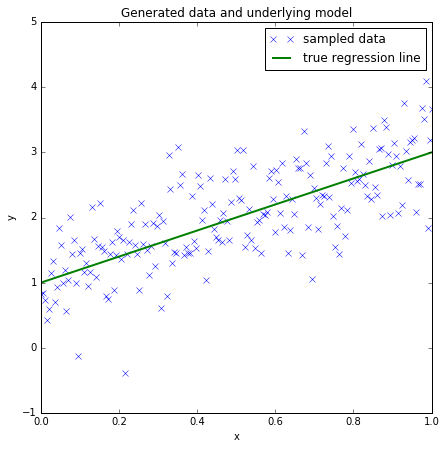

In [10]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel='x', ylabel='y', title='Generated data and underlying model')
ax.plot(x, y, 'x', label='sampled data')
ax.plot(x, true_regression_line, label='true regression line', lw=2.)
plt.legend(loc=0);

## Estimating the model



Lets fit a Bayesian linear regression model to this data. As you can see, model specifications in PyMC3 are wrapped in a **``with``** statement.


Some key parts of the code:

- likelihood is defined a Normal



Here we use the awesome new NUTS sampler (our Inference Button) to draw 2000 posterior samples.


In [52]:
pymc3.Poisson

pymc3.distributions.discrete.Poisson

In [47]:
pymc3.HalfCauchy

pymc3.distributions.continuous.HalfCauchy

In [82]:
with Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    sigma = pymc3.HalfCauchy('sigma', beta=10, testval=1.)
    #sigma = pymc3.Poisson('mu',  2)
    intercept = pymc3.Normal('Intercept', 0, sd=20)
    x_coeff = pymc3.Normal('x', 0, sd=20)
    
    # Define likelihood
    likelihood = pymc3.Normal('y', 
                              mu=intercept + x_coeff * x, 
                              sd=sigma, 
                              observed=y)
       
    # Inference!
    start = find_MAP() # Find starting value by optimization
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, start=start, progressbar=True) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sigma and added transformed sigma_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 3.3 sec



This should be fairly readable for people who know probabilistic programming. However, would my non-statistican friend know what all this does? Moreover, recall that this is an extremely simple model that would be one line in R. Having multiple, potentially transformed regressors, interaction terms or link-functions would also make this much more complex and error prone.

The new glm() function instead takes a Patsy linear model specifier from which it creates a design matrix. glm() then adds random variables for each of the coefficients and an appopriate likelihood to the model.


##### Details about find_MAP, NUTS, sample

- **``find_MAP``**: Sets state to the local maximum a posteriori point given a model. Current default of ``fmin_Hessian`` does not deal well with optimizing close to sharp edges, especially if they are the minimum.
    - Parameters
    
        - start(dict): of parameter values (Defaults to `model.test_point`)
        - vars (list): List of variables to set to MAP point (Defaults to all continuous).
        - fmin(function):  Optimization algorithm (Defaults to `scipy.optimize.fmin_bfgs` unless   discrete variables are specified in `vars`, then   `scipy.optimize.fmin_powell` which will perform better).
        - return_raw (Bool): Whether to return extra value returned by fmin (Defaults to `False`)
        - model (Model) it is optional if in `with` context
        
        
- **``NUTS``**: Automatically tunes step size and adjust number of steps for good performance.


In [102]:
#help(sample)

In [94]:
type(trace)

pymc3.backends.base.MultiTrace

In [103]:
#help(type(trace))

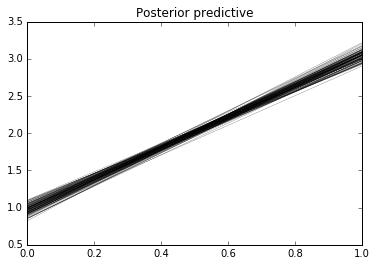

In [87]:

glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')

#### A shorter version of the code above

The following version is much shorter, but this code does the exact same thing as the above model specification (you can change priors and everything else too if we wanted). 

``glm()`` parses the ``Patsy`` model string, adds random variables for each regressor (``Intercept`` and slope x in this case), adds a likelihood (by default, a Normal is chosen), and all other variables (sigma). Finally, ``glm()`` then initializes the parameters to a good starting point by estimating a frequentist linear model using **statsmodels**.

- statsmodels: http://statsmodels.sourceforge.net/devel/


In [66]:
with Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and 
    # and all its parameters are automatically added to our model.
    glm.glm('y ~ x', data)
    start = find_MAP()
    step = NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = sample(2000, step, progressbar=True) # draw 2000 posterior samples using NUTS sampling

Applied log-transform to sd and added transformed sd_log_ to model.
 [-----------------100%-----------------] 2000 of 2000 complete in 3.9 sec

## Analyzing the model

Bayesian inference does not give us only one best fitting line (as maximum likelihood does) but rather a whole posterior distribution of likely parameters. Lets plot the posterior distribution of our parameters and the individual samples we drew.

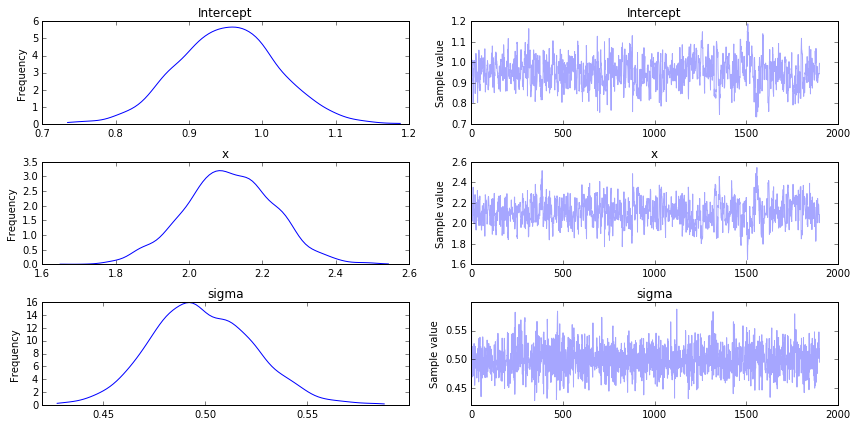

In [70]:
plt.figure(figsize=(7, 7))
traceplot(trace[100:])
plt.tight_layout();

The left side shows our marginal posterior:
- **for each parameter value on the x-axis we get a probability on the y-axis that tell us how likely that parameter value is**.

There are a couple of things to see here. The first is that our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).


Secondly, the maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters used to generate the data (x is the regression coefficient and sigma is the standard deviation of our normal).

Recall that we created the dataset using a line with incercept 1 and slope 2. Therefore the line had the form $y= 2x + 1$. Recall the code

    true_intercept = 1
    true_slope = 2
    x = np.linspace(0, 1, size)
    true_regression_line = true_intercept + true_slope * x

In the GLM we thus do not only have one best fitting regression line, but many. A posterior predictive plot takes multiple samples from the posterior (intercepts and slopes) and plots a regression line for each of them. Here we are using the ``glm.plot_posterior_predictive()`` convenience function for this.

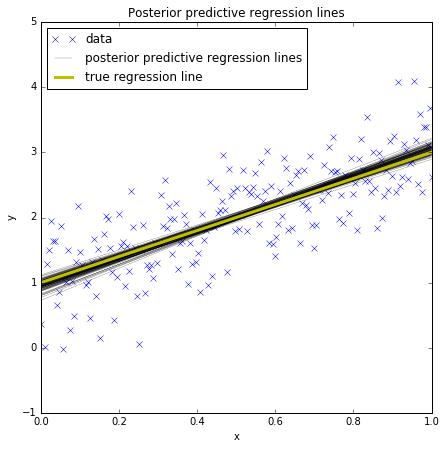

In [101]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')
plt.plot(x, true_regression_line, label='true regression line', lw=3., c='y')

plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');




As you can see, our estimated regression lines are very similar to the true regression line. But since we only have limited data we have uncertainty in our estimates, here expressed by the variability of the lines.


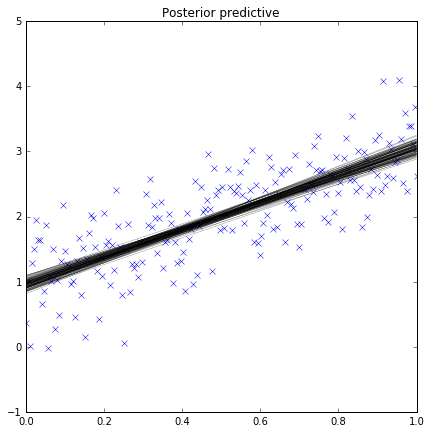

In [81]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
glm.plot_posterior_predictive(trace, samples=100, 
                              label='posterior predictive regression lines')

# Bayesian linear regression 3D

- Example extended from:  http://pymc-devs.github.io/pymc3/notebooks/getting_started.html

Now let us revisit again how to define, git and do posterior analysis in a regression setting with 2 predictor variables $X_1$ and $X_2$ and a set of prediction outcomes $Y$.

We are interested in predicting outcomes $Y$ which we assume as normally distributed observations with an expected value $\mu$ that is a linear function of our two predictor variables. That means

\begin{equation}
Y \sim \mathcal{N} (\mu, \sigma^2)
\end{equation}

\begin{equation}
\mu = \alpha + \beta_1 X_1 + \beta_2 X_2
\end{equation}

where:
- $\alpha$ is the intercept term.
- $\beta_i$ is the coefficient for covariate $X_i$ (or the weight associated to $X_i$).
- $\sigma$ represents the observation error.

**Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior distribution**.

- We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to weak information regarding the true parameter values.

\begin{equation}
\beta_i \sim \mathcal{N} (0,100)
\end{equation}


- We choose zero-mean normal prior with variance of 100 for the intercept term.

\begin{equation}
\alpha \sim \mathcal{N} (0,100)
\end{equation}


- We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.


\begin{equation}
\sigma \sim \left| \mathcal{N} (0,1) \right|
\end{equation}


#### Generate artificial data

We can simulate some artificial data from this model using only NumPy’s ``random`` module, and then use PyMC3 to try to recover the corresponding parameters. We are intentionally generating the data to closely correspond the PyMC3 model structure.

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize random number generator
np.random.seed(123)

# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0]*X1 + beta[1]*X2 + np.random.randn(size)*sigma

Here is what the simulated data look like. We use the pylab module from the plotting library matplotlib.

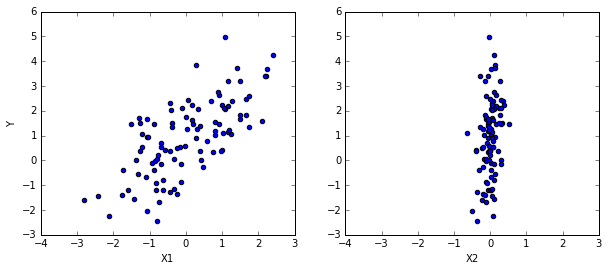

In [67]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

## Model Specification

Specifying this model in PyMC3 is straightforward because the syntax is as close to the statistical notation. For the most part, each line of Python code corresponds to a line in the model notation above.

First, we import the components we will need from PyMC.

In [16]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from pymc3.distributions import  Normal, HalfNormal
from pymc3 import Model

Now we build our model, which we will present in full first, then explain each part line-by-line.

In [29]:
basic_model = Model()

with basic_model:

    # Priors for unknown model parameters
    alpha = Normal('alpha', mu=0, sd=10)
    beta = Normal('beta', mu=0, sd=10, shape=2)
    sigma = HalfNormal('sigma', sd=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)

Applied log-transform to sigma and added transformed sigma_log_ to model.


In [14]:
print("type of alpha", type(alpha))
print("type of Y_obs",type(beta))
print("type of mu", type(mu))
print("type of Y_obs",type(Y_obs))

('type of alpha', <class 'pymc3.model.FreeRV'>)
('type of Y_obs', <class 'pymc3.model.FreeRV'>)
('type of mu', <class 'theano.tensor.var.TensorVariable'>)
('type of Y_obs', <class 'pymc3.model.ObservedRV'>)


#### In depth description of the construction of ``basic_model``

The first line

```python
    basic_model = Model()
```

- creates a new ``pymc3.Model`` object which is a container for the model random variables.

In [15]:
type(basic_model)

pymc3.model.Model

Following instantiation of the model, the subsequent specification of the model components is performed inside a with statement:

```python
with basic_model:
```

- This creates a context manager, with our **``basic_model``** as the context, that includes all statements until the indented block ends. This means all PyMC3 objects introduced in the indented code block below the **``with``** statement are added to the model behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with **``basic_model``** right after we create them. If you try to create a new random variable without a **``with model``**: statement, it will raise an error since there is no obvious model for the variable to be added to.

### 1) Defining prior distributions on the parameters 
The first three statements in the context manager:

```python
alpha = Normal('alpha', mu=0, sd=10)
beta = Normal('beta', mu=0, sd=10, shape=2)
sigma = HalfNormal('sigma', sd=1)
```

create  **stochastic random variables** with
- a Normal prior distributions for the regression coefficients with  mean 0 and std 10.

- a Normal prior distributions for the intercept with mean 0 and std 10.

- a half-normal distribution for the standard deviation of the observations, $\sigma$.

These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and partly random (or stochastic).

We call the **``Normal``** constructor to create a random variable to use as a normal prior.

- The first argument is always the name of the random variable, which should almost always match the name of the Python variable being assigned to, since it sometimes used to retrieve the variable from the model for summarizing output. 
-  The remaining required arguments for a stochastic object are the parameters, in this case **``mu``**, the mean, and **``sd``**, the standard deviation, which we assign hyperparameter values for the model.
- In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly used distributions, such as **``Beta``**, **``Exponential``**, **``Categorical``**, **``Gamma``**, **``Binomial``** and many others, are available in PyMC3.

- Notice that the **``beta``** variable has an additional shape argument to denote it as a vector-valued parameter of size 2. The **``shape``** argument is availabel for all distributions and  specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. 
    - It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (e.g. shape=(5,7) makes random variable that takes on 5 by 7 matrix values).

### 2) Defining a (Deterministic) model for the outcomes

Having defined the priors, the next statement creates the expected value **``mu``** of the outcomes. In this case we specify a linear relationship:

```python
mu = alpha + beta[0]*X1 + beta[1]*X2
```

This creates a **deterministic random variable**, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values. Here, **``mu``** is just the sum of the intercept **``alpha``** and the two products of the coefficients in **``beta``** and the predictor variables, whatever their values may be.


PyMC3 random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like  **``sum``**, **``sin``**, **``exp``**, and linear algebra functions like  **``dot``** (for inner product) and  **``inv``** (for inverse) are also provided.


### 3) Defining a sampling distribution of the outcomes in the dataset


The final line of the model defines  **``Y_obs``**, the sampling distribution of the outcomes in the dataset.

```python
Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
```
- This is a special case of stochastic variable that is called **observed stochastic** and it represents the likelihood of the model. It is identical to a standard stochastic except the  **``observed``** argument, which passes the data to the variable, indicates that the values for this variable were observed and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of eigher a   **``numpy.ndarray``** , or a **``pandas.DataFrame``**  object.

- Notice that unlike the priors of the model the parameters for the normal distribution of **``Y_obs``** are not fixed values, but rather are the deterministic object **``mu``** and the stochastic **``sigma``**. This creates the parent-child relationships between the likelihood and these two variables.


In [129]:
type(Y_obs)

pymc3.model.ObservedRV

In [130]:
type(alpha)

pymc3.model.FreeRV

## Bayesian Model fitting: MAP vs Sampling

Having completely specified our model, the next step is to obtain posterior estimates for the unknown variables in the model. Ideally, we could calculate the posterior estimates analytically, but for most non-trivial models, this is not feasible. We will consider two approaches, whose appropriateness depends on the structure of the model and the goals of the analysis:

- finding the maximum a posteriori (MAP) point using optimization methods, 
- computing summaries based on samples drawn from the posterior distribution using Markov Chain Monte Carlo (MCMC) sampling methods.


### Bayesian model fitting: Maximum a posteriori methods


The **maximum a posteriori (MAP)** estimate for a model, is the mode of the posterior distribution and is generally found using numerical optimization methods. This is often fast and easy to do, but only gives a point estimate for the parameters and can be biased if the mode isn’t representative of the distribution.

For example the MAP of the following density is in the middle of the right hand side little mountain even thought most of the probability mass is in the first bump of the density.
<img src="./images/Bimodal_density.svg">


PyMC3 provides this functionality with the **``find_MAP``** function.

Below we find the MAP for our original model. **The MAP is returned as a parameter point**, which is always represented by a Python dictionary of variable names to NumPy arrays of parameter values.


In [144]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=basic_model)

print(map_estimate)

{'beta': array([ 0.94848602,  2.60705514]), 'alpha': array(0.9065985497583454), 'sigma_log_': array(-0.0327814701740585)}


By default, **``find_MAP``** uses the Broyden–Fletcher–Goldfarb–Shanno (BFGS) optimization algorithm to find the maximum of the log-posterior but also allows selection of other optimization algorithms from the **`` scipy.optimize``**  module. For example, below we use Powell’s method to find the MAP.

In [20]:
from scipy import optimize

map_estimate = find_MAP(model=basic_model, fmin=optimize.fmin_powell)

print(map_estimate)

{'alpha': array(0.9090521896381254), 'beta': array([ 0.95140146,  2.61437458]), 'sigma_log_': array(-0.030009775414993233)}


**It is important to note that the MAP estimate is not always reasonable, especially if the mode is at an extreme**. **This can be a subtle issue; with high dimensional posteriors, one can have areas of extremely high density but low total probability because the volume is very small**. This will often occur in hierarchical models with the variance parameter for the random effect. If the individual group means are all the same, the posterior will have near infinite density if the scale parameter for the group means is almost zero, even though the probability of such a small scale parameter will be small since the group means must be extremely close together.

Most techniques for finding the MAP estimate also only find a local optimum (which is often good enough), but can fail badly for multimodal posteriors if the different modes are meaningfully different.

### Bayesian model fitting: Sampling methods


Though finding the MAP is a fast and easy way of obtaining estimates of the unknown model parameters, it is limited because there is no associated estimate of uncertainty produced with the MAP estimates. Instead, a simulation-based approach such as Markov chain Monte Carlo (MCMC) can be used to obtain a Markov chain of values that, given the satisfaction of certain conditions, are indistinguishable from samples from the posterior distribution.



To conduct MCMC sampling to generate posterior samples in PyMC3, we specify a **step method** object that corresponds to a particular MCMC algorithm, such as Metropolis, Slice sampling, or the No-U-Turn Sampler (NUTS). PyMC3’s **``step_methods``** submodule contains the following samplers: 
- **``NUTS``** ,
- **``Metropolis``** ,
- **``Slice``** , 
- **``HamiltonianMC``** ,
- **``BinaryMetropolis``** 

These step methods can be assigned manually, or assigned automatically by PyMC3. Auto-assignment is based on the attributes of each variable in the model. In general:

- Continuous variables will be assigned to **``NUTS``** 
- Discrete variables will be assigned to  **``Metropolis``** 
- Binary variables will be assigned to **``BinaryMetropolis``** 

**Auto-assignment can be overriden for any subset of variables by specifying them manually prior to sampling.**


### Bayesian model fitting: Sampling  with Grad-based methods (NUTS)

PyMC3 has the standard sampling algorithms like adaptive Metropolis-Hastings and adaptive slice sampling, but **PyMC3’s most capable step method is the No-U-Turn Sampler (NUTS)**.

**NUTS is especially useful on models that have many continuous parameters**, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentiation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. **For random variables that are undifferentiable (namely, discrete variables) NUTS cannot be used, but it may still be used on the differentiable variables in a model that contains undifferentiable variables.**

NUTS requires a scaling matrix parameter, which is analogous to the variance parameter for the jump proposal distribution in Metropolis-Hastings, although NUTS uses it somewhat differently. The matrix gives the rough shape of the distribution so that NUTS does not make jumps that are too large in some directions and too small in other directions. It is important to set this scaling parameter to a reasonable value to facilitate efficient sampling. This is especially true for models that have many unobserved stochastic random variables or models with highly non-normal posterior distributions. Poor scaling parameters will slow down NUTS significantly, sometimes almost stopping it completely. A reasonable starting point for sampling can also be important for efficient sampling, but not as often.

Fortunately NUTS can often make good guesses for the scaling parameters. If you pass a point in parameter space (as a dictionary of variable names to parameter values, the same format as returned by **``find_MAP``**) to NUTS, it will look at the local curvature of the log posterior-density (the diagonal of the Hessian matrix) at that point to make a guess for a good scaling vector, which often results in a good value. 

#### Good way to initialize NUTS

- **The MAP estimate is often a good point to use to initiate sampling. It is also possible to supply your own vector or scaling matrix to NUTS, though this is a more advanced use.** If you wish to modify a Hessian at a specific point to use as your scaling matrix or vector, you can use **``find_hessian``** or **``find_hessian_diag``**.

## Back to the bayesian fitting of our basic_model

For our basic linear regression example in **``basic_model``**, we will 

- find the MAP, then use it as the starting point and scaling point of the NUTS sampler. This must also be performed inside the context of the model.
- use NUTS to sample 2000 draws from the posterior


#### QUESTION: How does basic_model know where the data is?
- We do not pass in the context of basic_model X1 or X2 yet the model seems to be trained

In [55]:
from pymc3 import NUTS, sample
from scipy import optimize

with basic_model:
    #import pdb;pdb.set_trace()
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # draw 2000 posterior samples
    trace = sample(2000, start=start)

Assigned NUTS to alpha
Assigned NUTS to beta
Assigned NUTS to sigma_log_
 [-----------------100%-----------------] 2000 of 2000 complete in 2.5 sec

In [56]:
start

{'alpha': array(0.9090521896381254),
 'beta': array([ 0.95140146,  2.61437458]),
 'sigma_log_': array(-0.030009775414993233)}

The **``sample``** function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns a **``Trace``** object containing the samples collected, in the order they were collected. The **``trace``** object can be queried in a similar way to a **``dict``** containing a map from variable names to **``numpy.arrays``**. The first dimension of the array is the sampling index and the later dimensions match the shape of the variable. We can see the last 5 values for the **``alpha``** variable as follows:

In [57]:
trace['alpha'][-5:]

array([ 0.90104435,  0.941226  ,  0.95430559,  0.79636818,  1.02943728])

If we wanted to use the slice sampling algorithm to **``sigma``** instead of NUTS (which was assigned automatically), we could have specified this as the **``step``** argument for **``sample``**.

In [64]:
from pymc3 import Slice

with basic_model:

    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)

    # instantiate sampler
    #step = Slice(vars=[sigma])

    # draw 5000 posterior samples
    trace = sample(5000, step=step, start=start)

Assigned NUTS to alpha
Assigned NUTS to beta
 [-----------------100%-----------------] 5000 of 5000 complete in 26.9 sec

## TODO: plot the solution reached after learning

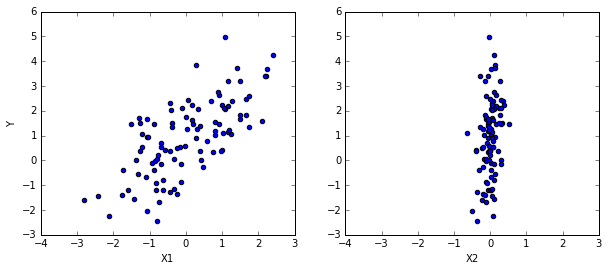

In [59]:
%matplotlib inline

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,4))
axes[0].scatter(X1, Y)
axes[1].scatter(X2, Y)
axes[0].set_ylabel('Y'); axes[0].set_xlabel('X1'); axes[1].set_xlabel('X2');

## Posterior Analysis

PyMC3 provides plotting and summarization functions for inspecting the sampling output. A simple posterior plot can be created using **``traceplot``**.

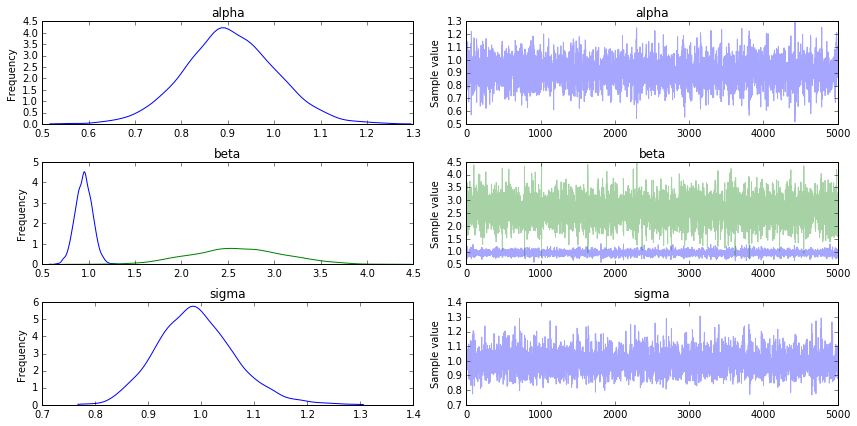

In [50]:
from pymc3 import traceplot

traceplot(trace);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The **``beta``** variable, being vector-valued, produces two histograms and two sample traces, corresponding to both predictor coefficients.

In addition, the **``summary``** function provides a text-based output of common posterior statistics:

In [151]:
from pymc3 import summary

summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.909            0.097            0.001            [0.720, 1.103]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.715          0.846          0.912          0.973          1.099


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.950            0.089            0.001            [0.769, 1.115]
  2.610            0.505            0.006            [1.646, 3.636]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.779          0.890          0.950          1.010          1.127
  1.609          2.276          2.618   

# Fitting an MLP to the previous data

#### model Specification

In [186]:
X_train = np.vstack((X1,X2)).T
Y_train = Y 

In [176]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights between each layer
init_1 = np.random.randn(X_train.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

The Normal priors help regularize the weights. **Usually we would add a constant b to the inputs but I omitted it here to keep the code cleaner.**

In [111]:
T.nnet.relu

<function theano.tensor.nnet.nnet.relu>

In [145]:
import theano.tensor as T
import pymc3 as pm

with pm.Model() as neural_network:
    
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=0.1, 
                             shape=(X_train.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=0.1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=0.1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network using tanh activation function
    act_1 = T.nnet.relu(T.dot(ann_input, 
                         weights_in_1))
    
    act_2 = T.nnet.relu(T.dot(act_1, 
                         weights_1_2))
    
    act_out = T.dot(act_2, weights_2_out)
    
    # Binary classification -> Bernoulli likelihood
    #out = pm.Bernoulli('out', 
    #                   act_out,
    #                   observed=ann_output)
    
    Y_obs = pm.Normal('Y_obs', observed=Y)
    
    

In [153]:
neural_network.observed_RVs

[Y_obs]

In [166]:
with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Iteration 0 [0%]: ELBO = -5269.58
Iteration 5000 [10%]: Average ELBO = -3065.9
Iteration 10000 [20%]: Average ELBO = -1324.49
Iteration 15000 [30%]: Average ELBO = -1175.51
Iteration 20000 [40%]: Average ELBO = -1169.74
Iteration 25000 [50%]: Average ELBO = -1169.3
Iteration 30000 [60%]: Average ELBO = -1169.36
Iteration 35000 [70%]: Average ELBO = -1169.24
Iteration 40000 [80%]: Average ELBO = -1169.33
Iteration 45000 [90%]: Average ELBO = -1169.18
Finished [100%]: Average ELBO = -1169.24


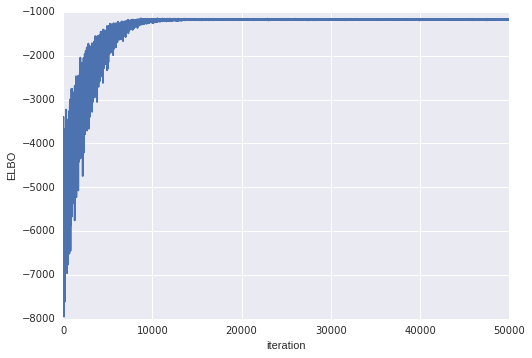

In [167]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration')

#### Get predictions from neural_network

In [179]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

ValueError: x and y must be the same size

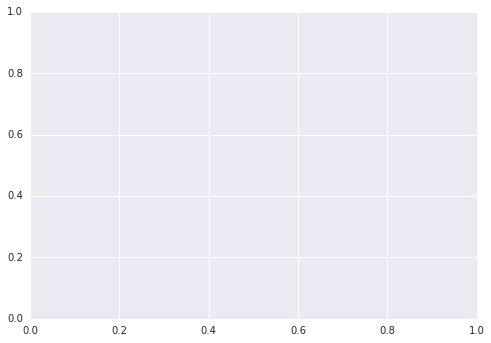

In [185]:
fig, ax = plt.subplots()
ax.scatter(X_train[:,0],y_train)
#ax.scatter(X_train[:,0],ppc, color='r')



# Bayesian neural networks for classification

## PyMC3: Bayesian MLP for classification


#### pymc tutorial

- Bayesian Parameter Estimation for Bernoulli Distribution: 
    - http://alfan-farizki.blogspot.com.es/2015/07/pymc-tutorial-bayesian-parameter.html
    
    
#### bayeseian method for nnets FAQ

- http://www.inference.phy.cam.ac.uk/mackay/Bayes_FAQ.html

In [3]:
import pymc3
from pymc3 import *

In [4]:
with Model() as model:
    location = Uniform("location", lower=-1, upper=1)
    scale    = Uniform("scale", lower=0, upper=1.)
    tail     = Uniform("tail", lower=1, upper=20)
    
    obs = pymc3.distributions.StudentT("daily returns",
                                       mu= location,
                                       sd=scale,
                                       nu=tail)
                                       #observed=returns_in_sample
                                      #)
    sampler = NUTS()
    trace = sample(5000, sampler)

Applied interval-transform to location and added transformed location_interval_ to model.
Applied interval-transform to scale and added transformed scale_interval_ to model.
Applied interval-transform to tail and added transformed tail_interval_ to model.
 [----             11%                  ] 554 of 5000 complete in 6.2 sec

# Bayesian MLP with pymc

In [120]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification

In [123]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

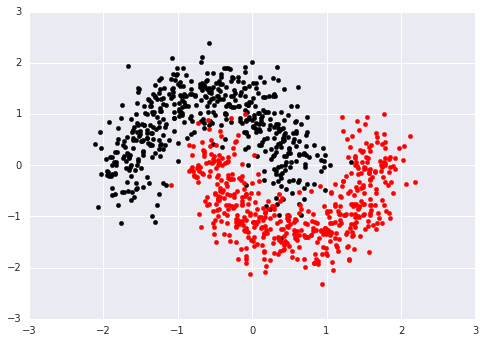

In [122]:
plt.scatter(X[Y==0, 0], X[Y==0, 1], color = "black")
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

In [37]:
# Turn inputs and outputs into shared variables so that we can change them later

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights.
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)


In [39]:
neural_network

In [42]:
help(pm.Metropolis)

Help on class Metropolis in module pymc3.step_methods.metropolis:

class Metropolis(pymc3.step_methods.arraystep.ArrayStepShared)
 |  Metropolis-Hastings sampling step
 |  
 |  Parameters
 |  ----------
 |  vars : list
 |      List of variables for sampler
 |  S : standard deviation or covariance matrix
 |      Some measure of variance to parameterize proposal distribution
 |  proposal_dist : function
 |      Function that returns zero-mean deviates when parameterized with
 |      S (and n). Defaults to normal.
 |  scaling : scalar or array
 |      Initial scale factor for proposal. Defaults to 1.
 |  tune : bool
 |      Flag for tuning. Defaults to True.
 |  tune_interval : int
 |      The frequency of tuning. Defaults to 100 iterations.
 |  model : PyMC Model
 |      Optional model for sampling step. Defaults to None (taken from context).
 |  
 |  Method resolution order:
 |      Metropolis
 |      pymc3.step_methods.arraystep.ArrayStepShared
 |      pymc3.step_methods.arraystep.Bloc

In [28]:
with neural_network:    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)[5000:]

 [-----------------100%-----------------] 10000 of 10000 complete in 15.8 sec

### Predict Hold-out data

In [29]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

pred = ppc['out'].mean(axis=0) > 0.5

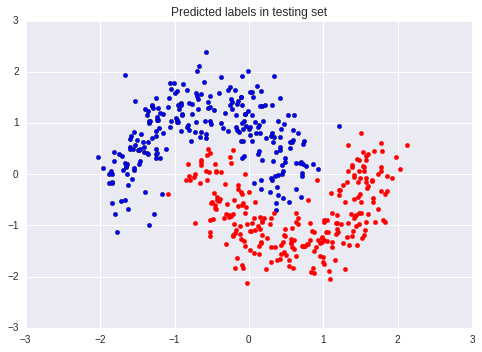

In [30]:
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
plt.title('Predicted labels in testing set')

In [1]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

NameError: name 'Y_test' is not defined

## classifier posterior

In [32]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)


In [33]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

#### probability of label ==1

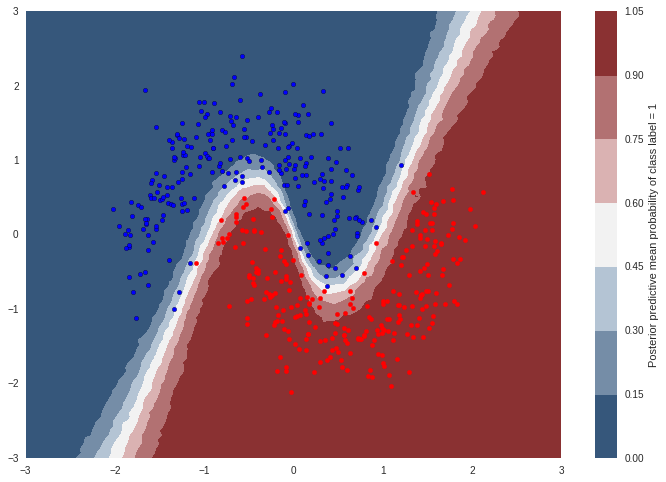

In [35]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3));
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1')

## Uncertainty in predicted value

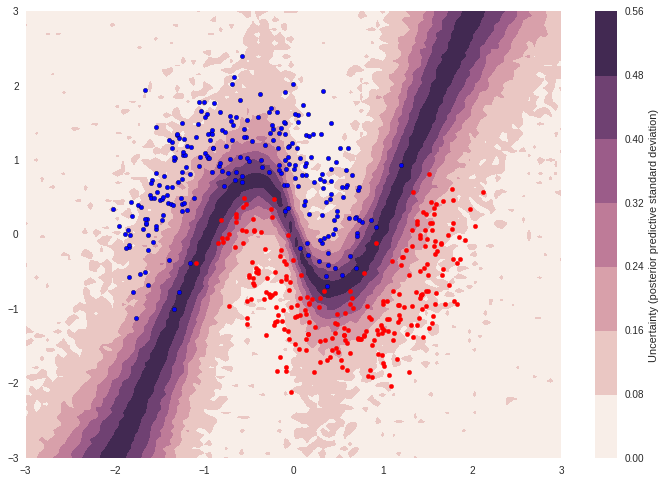

In [36]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3));
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')



This is really neat -- because we're in a Bayesian framework we get uncertainty in our predictions. You can see that very close to the decision boundary, our uncertainty as to which label to predict is highest.
